In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

### Load dataset

In [2]:
sc = MinMaxScaler(feature_range = (0, 1))

dataset = pd.read_csv("data/test.txt")

In [3]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,1,2,3,5,8,9,12,12,11,10,...,12,8,13,17,24,28,33,34,31,0
1,5,5,4,6,6,7,6,7,6,7,...,23,22,23,20,19,21,19,13,10,0
2,6,6,6,5,6,6,5,5,4,2,...,21,26,28,28,27,23,14,8,11,0
3,2,5,7,8,9,10,11,11,6,8,...,52,44,32,26,30,21,21,19,22,0
4,8,9,10,11,10,7,8,7,6,2,...,16,18,20,27,26,25,24,24,27,0


### Test plot 

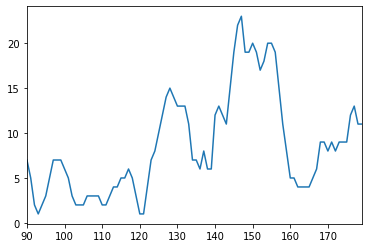

In [4]:
dataset.iloc[0][90:180].plot()

### Correlation matrix

In [17]:
count = dataset.shape[0]

#### Correlation matrix of groups by different sensors

In [18]:
group_correlation = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        for k in range(count):
            group_correlation[i,j] += np.corrcoef(dataset.iloc[k][i:i+90],dataset.iloc[k][j:j+90])[0][1]
        group_correlation[i,j] = group_correlation[i,j]/count

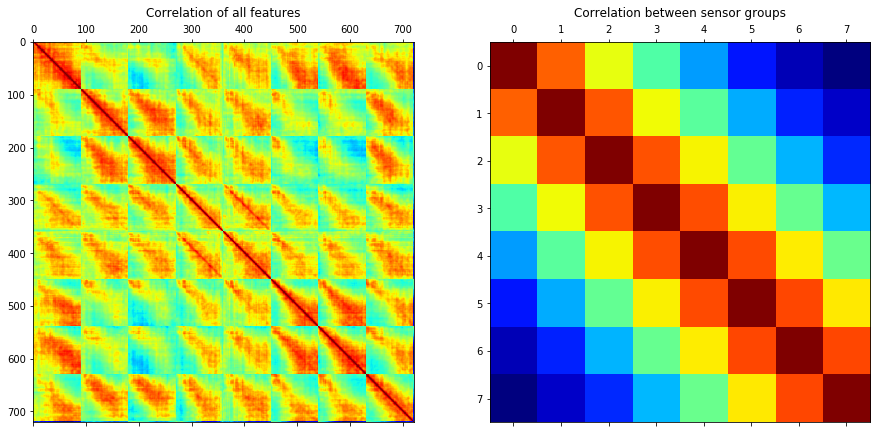

In [31]:

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
axes[0].matshow(dataset.corr(), cmap='jet')
axes[0].set_title("Correlation of all features")
axes[1].matshow(group_correlation, cmap='jet')
axes[1].set_title("Correlation between sensor groups")
plt.show()



### Distribution

In [32]:
dist = [[],[],[],[],[],[],[],[]]
for i in (range(8)):
    a = []
    for k in range(count):
        
        a = np.concatenate((a,np.array(dataset.iloc[k][i:i+90].values)),axis=None)
    dist[i] = a



Text(0.5, 1.0, 'Values distribution of EMG 8')

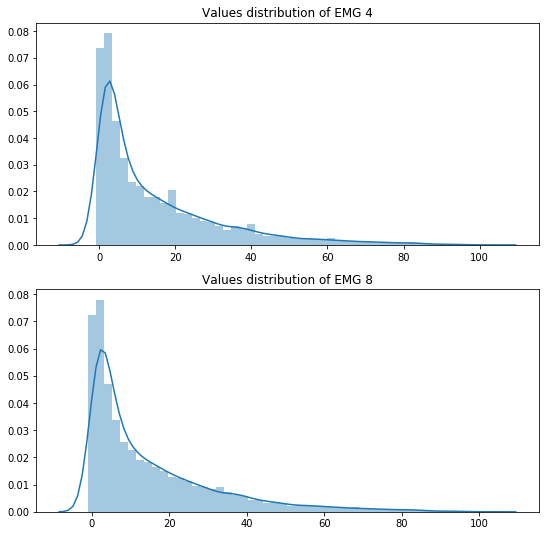

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(9,9))
plt.subplot(2,1,1)
sns.distplot(dist[3]);
plt.title("Values distribution of EMG 4")
plt.subplot(2,1,2)
sns.distplot(dist[7]);
plt.title("Values distribution of EMG 8")


### Shuffle

In [77]:
dataset_train = dataset.iloc[np.random.permutation(len(dataset))]
dataset_train.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,3,3,4,5,4,5,6,7,7,6,...,6,6,6,6,4,5,4,3,2,1
1,1,1,1,1,2,2,2,3,4,4,...,11,12,7,8,5,14,19,23,27,0
2,3,4,4,4,4,4,4,5,4,6,...,12,13,11,11,12,11,8,8,6,1
3,1,3,4,5,6,7,6,6,5,5,...,21,22,25,22,22,25,30,36,36,0
4,2,2,2,3,3,2,3,2,3,3,...,30,30,30,26,22,22,19,21,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,1,2,2,2,2,2,2,2,2,2,...,15,14,11,6,4,6,6,4,3,2
168,5,5,4,4,3,1,2,2,3,4,...,42,40,35,23,16,6,12,13,14,1
169,1,2,2,3,3,3,3,2,2,1,...,2,2,2,2,2,1,1,0,0,2
170,2,1,1,1,1,1,2,2,2,2,...,2,2,2,2,2,2,2,2,1,2


### Preprocessing of data

In [78]:
X_train = []
y_train = []

for i in range(0, dataset_train.shape[0]):
    row = np.array(dataset_train.iloc[i:1+i, 0:720].values)
    X_train.append(np.reshape(row, (720, 1)))
    y_train.append(np.array(dataset_train.iloc[i:1+i, -1:])[0][0])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

In [79]:
# Reshape to one flatten vector
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], 1)
X_train = sc.fit_transform(X_train)

In [80]:
X_train = X_train.reshape((-1, 8, 90))

In [81]:
# Convert to one hot
y_train = np.eye(np.max(y_train) + 1)[y_train]

In [82]:
print("All Data size X and y")
print(X_train.shape)
print(y_train.shape)

# Splitting Train/Test
X_test = X_train[90:]
y_test = y_train[90:]
print("Test Data size X and y")
print(X_test.shape)
print(y_test.shape)

X_train = X_train
y_train = y_train
print("Train Data size X and y")
print(X_train.shape)
print(y_train.shape)


All Data size X and y
(172, 8, 90)
(172, 3)
Test Data size X and y
(82, 8, 90)
(82, 3)
Train Data size X and y
(172, 8, 90)
(172, 3)


In [83]:
X_train.shape

(172, 8, 90)

### Creating model

In [84]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [85]:
classifier = Sequential()

classifier.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
classifier.add(Dropout(0.2))

classifier.add(LSTM(units = 50, return_sequences = True))
classifier.add(Dropout(0.2))

classifier.add(LSTM(units = 50, return_sequences = True))
classifier.add(Dropout(0.2))

classifier.add(LSTM(units = 50))
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 64))
classifier.add(Dense(units = 128))

classifier.add(Dense(units = 3, activation="softmax"))



In [86]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### Fitting model

In [87]:
history = classifier.fit(X_train, y_train,validation_split=0.25, epochs = 25, batch_size = 32, verbose=2)

Train on 129 samples, validate on 43 samples
Epoch 1/25
 - 2s - loss: 0.6349 - acc: 0.6667 - val_loss: 0.6361 - val_acc: 0.6667
Epoch 2/25
 - 0s - loss: 0.6232 - acc: 0.6667 - val_loss: 0.6417 - val_acc: 0.6667
Epoch 3/25
 - 0s - loss: 0.6119 - acc: 0.6667 - val_loss: 0.6224 - val_acc: 0.6667
Epoch 4/25
 - 0s - loss: 0.5959 - acc: 0.6667 - val_loss: 0.5803 - val_acc: 0.6667
Epoch 5/25
 - 0s - loss: 0.5647 - acc: 0.6770 - val_loss: 0.5245 - val_acc: 0.7364
Epoch 6/25
 - 0s - loss: 0.5273 - acc: 0.6796 - val_loss: 0.4746 - val_acc: 0.7364
Epoch 7/25
 - 0s - loss: 0.4565 - acc: 0.7752 - val_loss: 0.3912 - val_acc: 0.8682
Epoch 8/25
 - 0s - loss: 0.4192 - acc: 0.7881 - val_loss: 0.3374 - val_acc: 0.8450
Epoch 9/25
 - 0s - loss: 0.3273 - acc: 0.8553 - val_loss: 0.2778 - val_acc: 0.8605
Epoch 10/25
 - 0s - loss: 0.3307 - acc: 0.8217 - val_loss: 0.3985 - val_acc: 0.7209
Epoch 11/25
 - 0s - loss: 0.3413 - acc: 0.8191 - val_loss: 0.2852 - val_acc: 0.8605
Epoch 12/25
 - 0s - loss: 0.3812 - acc: 

In [88]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Text(0.5, 1.0, 'Accuracy')

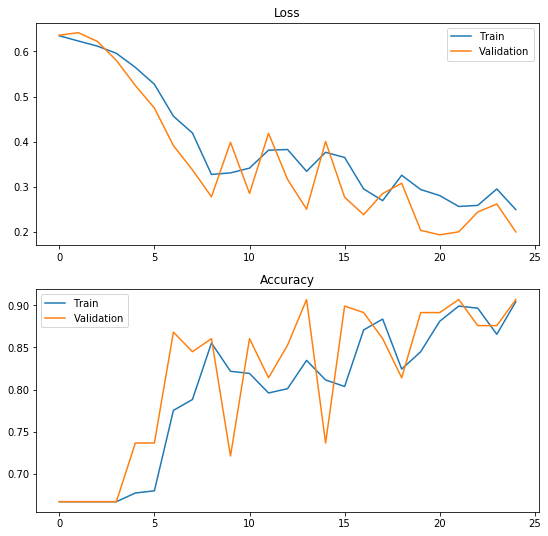

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(9,9))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Train","Validation"])
plt.title("Loss")
plt.subplot(2,1,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(["Train","Validation"])
plt.title("Accuracy")

In [70]:
classifier.evaluate(X_test, y_test)

82/82 [==============================] - 0s 219us/step


[0.19488503329637574, 0.9186991831151451]

### Save model

In [95]:
classifier.save("Data/test_armband.h5")
print("Saved model to disk")

Saved model to disk


### Save model for Unity (TensorFlowSharp)

In [98]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [99]:
from keras.models import load_model
from keras import backend as K

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

In [101]:
model = load_model('Data/test_armband.h5')

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [102]:
[out.op.name for out in model.outputs]

['dense_18_1/Softmax']

In [103]:
model.outputs

[<tf.Tensor 'dense_18_1/Softmax:0' shape=(?, 3) dtype=float32>]

In [104]:
model.inputs

[<tf.Tensor 'lstm_21_input_1:0' shape=(?, 8, 90) dtype=float32>]

In [68]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

INFO:tensorflow:Froze 413 variables.
Converted 413 variables to const ops.


In [69]:
tf.__version__

'1.4.0'

In [70]:
tf.train.write_graph(frozen_graph, "Models", "test_armband.pb", as_text=False)

'Models\\test_armband.pb'

In [72]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 90, 50)            11800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                20200     
__________

In [77]:
 x = np.array([1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,2,3,3,3,3,4,5,5,6,5,5,4,3,3,3,3,3,2,2,1,3,3,3,4,4,3,3,2,2,2,2,3,4,4,4,4,5,5,5,4,4,5,4,3,2,2,2,2,1,1,1,1,1,2,2,2,2,2,3,3,3,4,4,4,4,3,2,2,2,3,3,3,3,2,2,2,1,1,1,1,1,2,3,3,3,4,3,4,3,3,3,3,2,2,2,5,6,8,8,8,8,9,7,6,6,7,7,5,4,5,7,8,6,5,6,7,8,6,7,7,6,7,6,7,8,8,8,8,7,6,6,7,7,6,5,4,4,4,3,3,3,2,2,3,3,4,3,4,4,4,4,4,3,2,2,2,3,3,2,3,2,3,3,2,3,4,7,10,12,14,14,11,12,11,12,14,13,13,19,21,18,13,24,35,42,39,37,34,35,26,17,14,17,24,25,19,18,14,25,31,37,40,38,37,36,36,36,36,40,37,31,21,17,12,14,16,28,33,34,33,30,28,28,24,16,10,16,13,17,18,27,39,45,45,37,38,38,33,29,25,5,4,2,2,2,2,3,4,4,4,3,3,2,2,2,2,3,3,2,3,4,4,4,4,5,4,4,5,7,10,10,11,12,12,11,12,13,14,15,13,12,12,9,8,7,11,10,8,9,9,12,15,15,16,13,13,11,7,8,8,7,10,12,13,11,13,17,19,20,20,16,16,13,10,6,4,4,4,6,7,9,10,10,10,6,6,4,5,6,8,3,3,2,2,2,1,2,3,3,3,3,4,3,3,3,3,4,3,2,2,3,3,3,4,4,3,4,5,6,7,7,6,6,5,3,3,4,6,6,5,5,4,4,4,3,4,4,3,4,3,5,5,6,6,5,5,4,3,2,1,2,2,3,4,3,3,4,5,5,4,3,3,3,3,2,2,2,3,3,3,3,3,3,2,2,2,2,2,3,2,2,2,2,2,1,1,1,1,1,1,2,2,1,1,1,2,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,2,3,3,2,3,3,3,4,3,2,2,2,2,1,3,3,3,4,3,3,3,3,2,2,1,3,5,6,5,6,8,9,9,8,6,7,6,4,3,3,4,5,4,3,3,2,2,1,1,2,2,3,3,3,3,2,2,2,1,2,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,2,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,2,2,3,2,2,2,2,1,1,2,2,3,3,3,3,2,1,0,0,0,3,6,9,10,10,10,9,7,5,5,7,9,9,8,6,6,5,4,4,4,5,5,4,3,2,2,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,2,3,3,4,4,4,4,2,2,2,4,4,4,4,4,5,5,5,6,5,6,5,4,4,2,0,7,11,14,15,17,18,17,15,10,6,11,10,10,8,7,7,6,6,5,4,5,6,6,6,5,5,3,3,2])


In [79]:
x.reshape(1,8,90)

array([[[ 1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  3,
          3,  3,  3,  4,  5,  5,  6,  5,  5,  4,  3,  3,  3,  3,  3,  2,
          2,  1,  3,  3,  3,  4,  4,  3,  3,  2,  2,  2,  2,  3,  4,  4,
          4,  4,  5,  5,  5,  4,  4,  5,  4,  3,  2,  2,  2,  2,  1,  1,
          1,  1,  1,  2,  2,  2,  2,  2,  3,  3],
        [ 3,  4,  4,  4,  4,  3,  2,  2,  2,  3,  3,  3,  3,  2,  2,  2,
          1,  1,  1,  1,  1,  2,  3,  3,  3,  4,  3,  4,  3,  3,  3,  3,
          2,  2,  2,  5,  6,  8,  8,  8,  8,  9,  7,  6,  6,  7,  7,  5,
          4,  5,  7,  8,  6,  5,  6,  7,  8,  6,  7,  7,  6,  7,  6,  7,
          8,  8,  8,  8,  7,  6,  6,  7,  7,  6,  5,  4,  4,  4,  3,  3,
          3,  2,  2,  3,  3,  4,  3,  4,  4,  4],
        [ 4,  4,  3,  2,  2,  2,  3,  3,  2,  3,  2,  3,  3,  2,  3,  4,
          7, 10, 12, 14, 14, 11, 12, 11, 12, 14, 13, 13, 19, 21, 18, 13,
         24, 35, 42, 39,